# Create Journal Publication Figures

By: Adam Li

In this notebook, we generate figures from their figure source data. The source data comprises of a 10 nested cross-validation classification experiment, where we used neural fragility and other traditional feature representations of iEEG data around an ictal snapshot window to predict surgical outcome. For more information on the workflow, see the paper.

The experiment was ran on 91 patients collected over 4 years from 5 clinical centers. 

The `code/` directory contains some helper functions to help generate figures. The `data/` directory contains the figure source data and some metadata on clinical population. 

In [35]:
import os
import re
import json
import collections
from pprint import pprint
from pathlib import Path
import sys
import copy 

import numpy as np
import pandas as pd
import scipy
import scipy.io
from natsort import natsorted, index_natsorted
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
# matplotlib.use("Agg") # set matplotlib to use the backend that does not require a windowing system
from matplotlib import rc, ticker, cm
from pylab import *
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib

from mne import events_from_annotations
import mne
from mne_bids import read_raw_bids, BIDSPath
from mne_bids.path import _find_matching_sidecar, get_entities_from_fname
from mne_bids.tsv_handler import _to_tsv, _from_tsv

from code.utils import _load_turbo, _plot_roc_curve
from code.io import read_participants_tsv
_load_turbo()

# import statistics packages
import scipy.stats

import matplotlib
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "arial"

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import (average_precision_score, roc_auc_score, f1_score,
                            roc_curve, balanced_accuracy_score, accuracy_score, auc)
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from scipy import interp
from sklearn.metrics import (plot_precision_recall_curve, 
                             average_precision_score, 
                             precision_recall_curve)

# functions related to the feature comparison experiment
from mlxtend.evaluate import bootstrap_point632_score
import pingouin as pg
import dabest

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Utility Functions

In [71]:
def average_roc(fpr, tpr):
    """Compute average ROC statistics."""
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    
    n_splits = len(fpr)
    print(f"Computing average ROC over {n_splits} CV splits")
    for i in range(n_splits):
        interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(mean_fpr, interp_tpr))
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)   
    
    std_tpr = np.std(tprs, axis=0)
    return mean_fpr, tprs, aucs

In [24]:
from scipy.spatial.distance import cdist

# get line between optimum and clinical op point
def create_line(x1, x2, y1, y2, n_points=200):
    slope=(y2-y1)/(x2-x1)
    
    xs=np.linspace(x1,x2,n_points)
    ys=np.linspace(y1,y2,n_points)
    
    return xs, ys

def find_intersect_idx(x1s, y1s, x2s, y2s):
    """Help find intersection points between two curves."""
    euc_dists = []
    points = np.vstack((x2s, y2s)).T
    for idx, (x1, y1) in enumerate(zip(x1s, y1s)):
        point = np.array([x1, y1])[np.newaxis, :]
        dists = cdist(points, point)
        euc_dists.append(min(dists))
    return np.argmin(euc_dists)

In [73]:
def _get_subject_scores(scores, subjects):
    sub_scores = dict()
    for idx, (subject, score) in enumerate(zip(subjects, scores)):
        if subject not in sub_scores:
            sub_scores[subject] = np.mean(score)
    return sub_scores

In [25]:
def perf_metrics_2X2(yobs, yhat):
    """
    Returns the specificity, sensitivity, positive predictive value, and 
    negative predictive value 
    of a 2X2 table.

    where:
    0 = negative case
    1 = positive case

    Parameters
    ----------
    yobs :  array of positive and negative ``observed`` cases
    yhat : array of positive and negative ``predicted`` cases

    Returns
    -------
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)

    Author: Julio Cardenas-Rodriguez
    """
    TP = np.sum(  yobs[yobs==1.] == yhat[yobs==1.0] )
    TN = np.sum(  yobs[yobs==0.] == yhat[yobs==0.0] )
    FP = np.sum(  yobs[yobs==1.] == yhat[yobs==0.0] )
    FN = np.sum(  yobs[yobs==0.] == yhat[yobs==1.0] )

#     print(yhat)
#     print(TP, TN, FP, FN)
    sensitivity  = TP / (TP+FN)
    specificity  = TN / (TN+FP)
    pos_pred_val = TP/ (TP+FP)
    neg_pred_val = TN/ (TN+FN)

    return sensitivity, specificity, pos_pred_val, neg_pred_val

## Subjects

Note that subjects from their original identifiers were defined by clinicians collecting data. There was no sensible schema to naming, numbering or abbreviations, so we mapped these to patients in the paper as ``Patient_01``, ``Patient_02``, ... which is easier to then parse the clinical supplemental table.

In [72]:
# define list of subjects by their original identifiers
subjects = [
    "jh101", "jh103", "jh105", "jh108",
    "la00", "la01", "la02", "la03", "la04", "la05",
    "la06", "la07", "la08", "la09", "la10", "la11",
    "la12", "la13", "la15", "la16", "la17",
    "la20", "la21", "la22", "la23", "la24", "la27", "la28", "la29", "la31",
    "nl01", "nl03", "nl04", "nl05",
    "nl07", "nl08", "nl09", "nl10", "nl13", "nl14", "nl15",
    "nl16", "nl17", "nl18", "nl19", "nl20",
    "nl21", "nl22", "nl23", "nl24",
    "pt1", "pt2", "pt3", "pt6", "pt7",
    "pt8", "pt10", "pt11", "pt12",
    "pt13", "pt14", "pt15", "pt16", "pt17",
    "tvb1", "tvb2", "tvb5", "tvb7",
    "tvb8", "tvb11", "tvb12", "tvb14", "tvb17",
    "tvb18", "tvb19", "tvb23", "tvb27", "tvb28", "tvb29",
    "umf001", "umf002", "umf003", "umf004", "umf005",
    "ummc002", "ummc003", "ummc004", "ummc005", "ummc006",
    "ummc008", "ummc009",
]
print(len(subjects))

91


# Define Paths and some Metadata

In [14]:
# set seed and randomness for downstream reproducibility
seed = 123456
np.random.seed(seed)

In [15]:
# BIDS related directories
bids_root = Path("/Users/adam2392/Dropbox/epilepsy_bids/")
bids_root = Path("/home/adam2392/hdd2/Dropbox/epilepsy_bids/")
bids_root = Path('./data/')
deriv_path = bids_root / 'derivatives'

# output figures somewhere
figdir = Path('./') / 'figures'
figdir = Path(f'/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures/')
print(figdir)

# metadata table
excel_fpath = Path(
    "/home/adam2392/hdd2/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)
excel_fpath = Path(
    "/Users/adam2392/Dropbox/epilepsy_bids/sourcedata/organized_clinical_datasheet_raw.xlsx"
)

/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures


# Load and Combine Result JSONs into 1 data structure
Each cross-validation index was run separately and performance was saved separately into a JSON file. To evaluate all the cross-validation runs together, we load them from disc and combine them into 1 dictionary data structure to analyze.

In [75]:
# identifying strings for each feature representation of the data
feature_names = [
    'fragility',
    "delta", "theta", "alpha", "beta","gamma", "highgamma",
    'correlation-degree', 'correlation-centrality',
    'delta-coherence-centrality', 'theta-coherence-centrality', 'alpha-coherence-centrality',
    'beta-coherence-centrality', 'gamma-coherence-centrality', 'highgamma-coherence-centrality',
    'delta-coherence-degree', 'theta-coherence-degree', 'alpha-coherence-degree',
    'beta-coherence-degree', 'gamma-coherence-degree', 'highgamma-coherence-degree',
]
# clf_type = 'srerf'
clf_type = 'mtmorf'

study_path = deriv_path

In [17]:
# dictionary data structure to hold all the CV experiment results
nested_scores_feature = dict()

for feature_name in feature_names:
    # nested CV estimators
    nested_scores_search_pattern = f'study_nested_scores_{clf_type}_{feature_name}_*.json'
    nested_scores = None
    
    # get all json files that follow that search pattern
    fpaths = (study_path / 'quantile_features' / 'nestedcv_middlethresholds_-80to25_sampledcc_train70').glob(nested_scores_search_pattern)
    fpaths = natsorted(fpaths)
    for json_fpath in fpaths:
        with open(json_fpath, 'r') as fin:
            _nested_scores = json.load(fin)
        
        # either append to the nested dictionary, or create it
        # some magic done to cast numbers in case they were saved in different formats
        if nested_scores is None:
            for key, val in _nested_scores.items():
                if key in ['validate_ytrue']:
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                else:
                    continue
            nested_scores = _nested_scores
        else:
            for key, val in _nested_scores.items():
                if key == 'validate_ytrue':
                    val = val[0]
                    for idx, y in enumerate(val):
                        val[idx] = y[0]
                nested_scores[key].append(np.array(val).squeeze()) 
    print(f'There should be 10 total CV for {feature_name}. We found {len(fpaths)}')
    nested_scores_feature[feature_name] = nested_scores

There should be 10 total CV for fragility. We found 10
There should be 10 total CV for delta. We found 10
There should be 10 total CV for theta. We found 10
There should be 10 total CV for alpha. We found 10
There should be 10 total CV for beta. We found 10
There should be 10 total CV for gamma. We found 10
There should be 10 total CV for highgamma. We found 10
There should be 10 total CV for correlation-degree. We found 10
There should be 10 total CV for correlation-centrality. We found 10
There should be 10 total CV for delta-coherence-centrality. We found 10
There should be 10 total CV for theta-coherence-centrality. We found 10
There should be 10 total CV for alpha-coherence-centrality. We found 10
There should be 10 total CV for beta-coherence-centrality. We found 10
There should be 10 total CV for gamma-coherence-centrality. We found 10
There should be 10 total CV for highgamma-coherence-centrality. We found 10
There should be 10 total CV for delta-coherence-degree. We found 10
T

# Read in the Participants.tsv File Containing Clinical Metadata

The participants.tsv file contains clinical metadata. Let's get the clinical success rate of our dataset
and total success/failure counts.

In [76]:
pat_df = read_participants_tsv(bids_root)

display(pat_df.head())

,participant_id,age,sex,hand,outcome,engel_score,ilae_score,date_follow_up,ethnicity,years_follow_up,site,clinical_complexity
0,sub-jh101,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,4.0
1,sub-jh102,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,4.0
2,sub-jh103,NaN,NaN,NaN,F,4.0,6.0,NaN,NaN,1.0,JHH,3.0
3,sub-jh104,NaN,NaN,NaN,NR,-1.0,-1.0,NaN,NaN,1.0,JHH,3.0
4,sub-jh105,NaN,NaN,NaN,S,1.0,1.0,NaN,NaN,1.0,JHH,2.0


In [21]:
outcomes = []

# get a list of all the outcomes
for subj in np.unique(subjects):
    # use excel file to set various data points
    pat_row = pat_df[pat_df['participant_id'] == 'sub-' + subj]
    outcomes.append(pat_row['outcome'].values[0])
print(outcomes)

['F', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'S', 'S', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'F', 'S', 'S', 'S', 'S', 'S', 'F', 'F', 'S', 'F', 'F', 'F', 'F', 'S', 'S', 'F', 'F', 'F', 'F', 'F', 'F', 'S', 'F', 'S', 'S', 'F', 'F', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']


In [22]:
n_success = len(np.argwhere(np.array(outcomes) == 'S'))
clinical_sensitivity = n_success / len(outcomes)
clinical_fpr = (len(outcomes) - n_success) / len(outcomes)

print(f'Clinical sensitivity: {clinical_sensitivity}')
print(f'Clinical False Positive Rate: {clinical_fpr}')

Clinical sensitivity: 0.4835164835164835
Clinical False Positive Rate: 0.5164835164835165


# Compute the average Area Under Curve statistic across all CV indices

Note that in our experiment, we named the held-out test set `'validate_<metric>'`, and 
the corresponding `'test_<metric>'` is what we call our validation set in the nested cross-validation. This is just due to naming when using the scikit-learn API to run CV. For purposes in the paper of adhering to community standards of naming, we specify the following sets of data as:

    - train: the training dataset used to adjust the parameters of the classifier (i.e. in this case the Random Forest variant we used).
    - validation: The validation dataset used to adjust the hyperparameters
    - test: The final held-out test set used to evaluate the final classifier performance.


In [28]:
auc_feat_names = []
auc_feat_scores = []

for feature_name, nested_scores in nested_scores_feature.items():
    # summarize the boot-strapped samples
    fprs, tprs = nested_scores['validate_fpr'], nested_scores['validate_tpr']
    # aucs = [auc(fpr, tpr) for fpr, tpr in zip(fprs, tprs)]
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)
    
    auc_feat_names.append(feature_name)
    auc_feat_scores.append(np.mean(aucs))
    
auc_sorted_inds = np.argsort(auc_feat_scores)[::-1]
print(np.array(auc_feat_names)[auc_sorted_inds])

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
['fragility' 'beta' 'beta-coherence-centrality' 'alpha'
 'theta-coherence-centrality' 'alpha-coherence-centrality' 'gamma'
 'gamma-coherence-centrality' 'theta'

# Figure: ROC Curve(s) and their Statistics (AUC, PR, PPV, NPV)

Here we generate ROC curve(s) and their corresponding statistics.

In [57]:
# store all AUCs and Average Precision metrics
feature_aucs = dict()
feature_prs = dict()
feature_pred_names = []
feature_pred_probs = []
feature_pred_subs = []

# show some summary statements?
verbose = False

Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits
Computing average ROC over 10 CV splits


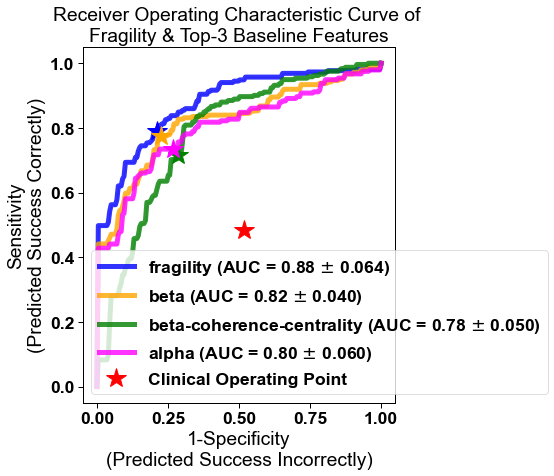

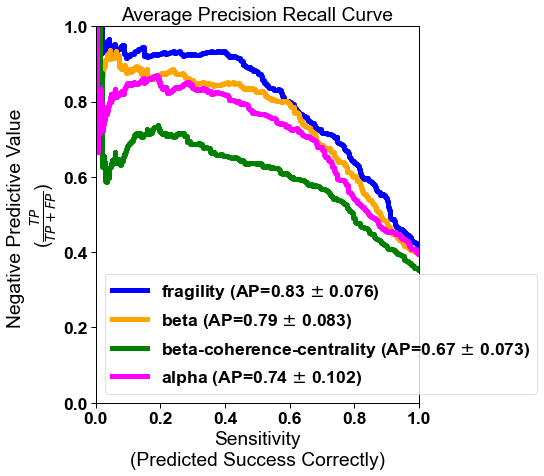

In [58]:
sns.set_context('paper', font_scale=2.0)

# figure to show ROC
fig, ax = plt.subplots(1, 1, figsize=(7,7))

# figure to show Precision plot
pfig, pax = plt.subplots(figsize=(7,7))

# color scheme
colors = ['blue', 'orange', 'green', 'magenta', 'black']

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(len(auc_feat_names)):
    # extract the feature name for plotting
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    
    # get the test set performances for this feature
    nested_scores = nested_scores_feature[feature_name]
    
    # extract the predicted probability of success, the true outcomes
    # for each 10 fold CV
    pat_predict_proba = nested_scores['validate_pat_predictions']
    pat_true = nested_scores['validate_pat_true']
    
    # initialize lists to store certain metrics we want to keep track of
    fprs = []
    tprs = []
    accs = []
    aps = []
    npvs = []
    ppvs = []
    ratio_succ = []
    ratio_fail = []
    n_succ = []
    n_fail = []
    
    # for visual sake only show the top 3 performing based on average AUC
    if idx > 3:
        idx = 4
    color = colors[idx]
    
    # loop through each CV fold (10 in total)
    for jdx in range(len(pat_true)):
        # in case data was stored in different formats, just pull them out
        # byproduct of saving w/ different encoding...
        if isinstance(pat_true[jdx], dict):
            pat_trues = pat_true[jdx]
            pat_predicts = pat_predict_proba[jdx]
        else:
            pat_trues = pat_true[jdx].item()
            pat_predicts = pat_predict_proba[jdx].item()
        
        # keep each patient's probability of success prediction, true outcome and list
        # of subjects in the test dataset
        pat_proba = []
        pat_y = []
        subjects = []
        for patient, pat_y_true in pat_trues.items():
            pat_probas = pat_predicts[patient]
            pat_mean_proba = np.mean(np.array(pat_probas).squeeze())

            pat_proba.append(pat_mean_proba)
            pat_y.append(pat_y_true)
            subjects.append(patient)
            
        # set the patient predictions based on the success probability prediction
        pat_predictions = np.where(np.array(pat_proba) > 0.5, 1, 0)
        
        # compute a balanced accuracy score of the predicted outcomes vs true outcomes
        acc = balanced_accuracy_score(pat_y, pat_predictions)
        
        # compute the number of failures/success per CV fold and the ratio of each
        n_true_succ = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 1])
        n_true_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if ytrue_ == 0])
        num_fail = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 0])
        num_success = len([y_ for y_, ytrue_ in zip(pat_predictions, pat_y) if y_ == ytrue_ if ytrue_ == 1])
        ratio_fail.append(num_fail / n_true_fail)
        ratio_succ.append(num_success / n_true_succ)
        n_fail.append(n_true_fail)
        n_succ.append(n_true_succ)
        
        # compute now the sensitivity, specificity, PPV, and NPV statistics
        sensitivity, specificity, pos_pred_val, neg_pred_val = perf_metrics_2X2(
            np.array(pat_y), np.array(pat_predictions))
        npvs.append(neg_pred_val)
        ppvs.append(pos_pred_val)
        
        # create the roc curve on this fold
        fpr, tpr, thresholds = roc_curve(pat_y, pat_proba)
        fprs.append(fpr)
        tprs.append(tpr)
        accs.append(acc)
        
        # store the subjects, predicted probabilities and feature names
        feature_pred_subs.extend(subjects)
        feature_pred_probs.extend(pat_proba)
        feature_pred_names.extend([feature_name] * len(pat_proba))

    ytrues, ypreds = nested_scores['validate_ytrue'], nested_scores['validate_ypred_prob']
    if verbose:
        ### Now compute statistics for summary, such as accuracies, f1scores, 
        accs = []
        f1s = []
        for ytrue, ypred in zip(ytrues, ypreds):
            ytrue = np.array(ytrue).squeeze()
            ypred = np.array(ypred).squeeze()
            ypred = np.array(ypred) > 0.5
            acc = balanced_accuracy_score(ytrue, ypred)
            f1score = f1_score(ytrue, ypred)
            accs.append(acc)
            f1s.append(f1score)
        
        print(f'\n\n{feature_name}')
        print(f'Balanced accuracy score: {np.mean(accs):.2f} +/- {np.std(accs):.2f}')
        print(f'F1 score: {np.mean(f1s):.2f} +/- {np.std(f1s):.2f}')
        print(f'Sensitivity: {youden_point[1]} and FPR: {youden_point[0]}')
        print('Improvement in FPR: ', np.round(youden_point[0]-clinical_fpr, 2))
        print('Improvement in TPR: ', np.round(youden_point[1]-clinical_sensitivity, 2))
        print('Total distance: ', np.linalg.norm((youden_point[0]-clinical_fpr, youden_point[1]-clinical_sensitivity)))
        print(f'Average Preicions: {np.mean(aps):.3f} +/- {np.std(aps):.3f}')
        print(f'Average NPVS: {np.mean(npvs):.3f} +/- {np.std(npvs):.3f}')
        print(f'Average PPVS: {np.mean(ppvs):.3f} +/- {np.std(ppvs):.3f}')
        print(f'Average failed ratio: {np.mean(ratio_fail):.3f} +/- {np.std(ratio_fail):.3f}')    
        print(f'Average success ratio: {np.mean(ratio_succ):.3f} +/- {np.std(ratio_succ):.3f}')    
    
        
    # compute the average ROC curve from the above loop over nested CV
    mean_fpr, tprs, aucs = average_roc(fprs, tprs)
    mean_tpr, std_tpr = np.mean(tprs, axis=0), np.std(tprs, axis=0)

    # compute the avg/std of the AUC statistic
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    feature_aucs[feature_name] = aucs
        
    # store average precisions, true outcome and predicted success probability
    avg_prec = []
    y_real = []
    y_proba = []
    for ytrue, ypred in zip(ytrues, ypreds):
        average_precision = average_precision_score(ytrue, ypred, pos_label=1.,
                                                     average=None)
        avg_prec.append(average_precision)
        y_real.append(ytrue)
        y_proba.append(ypred)
    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    
    # store all the average precisions per feature
    feature_prs[feature_name] = avg_prec
    
    if idx >= 4:
        continue
        
    # actually plot the ROC curve
    ax = _plot_roc_curve(mean_tpr, mean_fpr, 
                         mean_auc=mean_auc, std_auc=std_auc, 
                         label=feature_name, ax=ax, color=color, 
                         plot_chance=False)

    # plot youden point on the curve
    xs, ys = create_line(clinical_fpr, 0, clinical_sensitivity, 1)
    youden_idx = find_intersect_idx(mean_fpr, mean_tpr, xs, ys)
    youden_point = (mean_fpr[youden_idx], mean_tpr[youden_idx])
    ax.plot(youden_point[0], youden_point[1], marker='*', color=color, markersize=20, 
            linestyle='None', 
           )

    
    # generate a PR curve
    precision, recall, _ = precision_recall_curve(y_real, y_proba, pos_label=1)
#         lab = 'Overall Av=%.4f' % (auc(recall, precision))
    pax.step(recall, precision, lw=5, color=color, 
            label=f'{feature_name} (AP={np.mean(avg_prec):.2f} $\pm$ {np.std(avg_prec):.3f})')
    pax.set(title='Average Precision Recall Curve',
            xlim=[0, 1], ylim=[0, 1],
            xlabel='Sensitivity\n(Predicted Success Correctly)',
            ylabel='Negative Predictive Value \n'+ r'($\frac{TP}{TP+FP}$)')

######## format the ROC curve figure ########
ax.set(
    ylabel='Sensitivity\n(Predicted Success Correctly)',
    xlabel='1-Specificity\n(Predicted Success Incorrectly)',
    title='Receiver Operating Characteristic Curve of \nFragility & Top-3 Baseline Features',
#     xlim=[0, 0.05],
#     ylim=[0.4, 1],
)
# plot clinical point
ax.plot(clinical_fpr, clinical_sensitivity, 
        marker='*', color='red', markersize=20, 
        linestyle='None',
        label='Clinical Operating Point')
ax.legend(
#     ncol=2,
#     loc=(1.04, 0)
          )
pax.legend()
fig.tight_layout()
pfig.tight_layout()

# save figure to disc or not?
# pfig.savefig(figdir / f'figure4-discriminationandprecision/pr_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')
# fig.savefig(figdir / f'figure4-discriminationandprecision/roc_curve_{clf_type}_quantilefeatures.pdf',
#            bbox_inches='tight')

## Compare the AUC per feature

First, we'll construct a dataframe of each of the 10 folds and features considered.

Then, well create a plot of the AUCs per feature.

Next, we'll evaluate the statistics of this performance. Note that AUC is a metric for us to measure how well each feature represents the underlying epileptic network based on our classification experiment setup. So the higher the AUC distributions are, the better. 

We analyze how much better the predictions are by comparing the 

In [42]:
feature_aucs_df = pd.DataFrame.from_dict(feature_aucs)
feature_aucs_df['id_col'] = np.arange(10)

display(feature_aucs_df.head())

# melt the dataframe, so it can be plotted using seaborn
feature_aucs_df = pd.melt(feature_aucs_df, id_vars='id_col',
                          var_name='feature', value_name='auc')
# display  
feature_aucs_df.columns = [x.capitalize() if x in ['feature'] else x.upper() for x in feature_aucs_df.columns ]
feature_aucs_df['Feature'] = feature_aucs_df['Feature'].str.capitalize() 
display(feature_aucs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.937186,0.788751,0.825860,0.718013,0.764979,0.824608,0.844801,0.792424,0.825087,0.808852,...,0.839776,0.692501,0.664090,0.778701,0.724386,0.681678,0.672594,0.694434,0.570932,0
1,0.769203,0.734027,0.720669,0.799354,0.798667,0.749727,0.667265,0.758466,0.759512,0.790380,...,0.711043,0.693467,0.737854,0.701005,0.653157,0.742080,0.779222,0.662971,0.539983,1
2,0.967337,0.886217,0.789630,0.900933,0.829146,0.711425,0.891601,0.823892,0.880833,0.911701,...,0.891960,0.876167,0.689127,0.721823,0.653723,0.760164,0.642988,0.619461,0.594564,2
3,0.885858,0.835607,0.825104,0.754128,0.904915,0.886935,0.789304,0.833625,0.759153,0.709261,...,0.774587,0.683776,0.691392,0.785777,0.764802,0.836246,0.735726,0.694173,0.581084,3
4,0.954495,0.798995,0.781686,0.882189,0.777499,0.778894,0.799553,0.848409,0.864880,0.887772,...,0.915690,0.617253,0.712172,0.715243,0.711055,0.755165,0.668621,0.702401,0.658571,4


,ID_COL,Feature,AUC
0,0,Fragility,0.937186
1,1,Fragility,0.769203
2,2,Fragility,0.967337
3,3,Fragility,0.885858
4,4,Fragility,0.954495


In [44]:
# map feature names to short-hand
feature_aucs_df['Feature'] = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('Correlation', 'Corr') for x in feature_aucs_df['Feature']]

order = feature_aucs_df.groupby('Feature').median().sort_values(by='AUC', ascending=False)
print(order.index.tolist())

['Fragility', 'Beta', 'Gamma-coh-cent', 'Theta-coh-cent', 'Delta', 'Gamma', 'Theta', 'Highgamma', 'Beta-coh-cent', 'Alpha', 'Alpha-coh-cent', 'Corr-cent', 'Highgamma-coh-cent', 'Delta-coh-cent', 'Beta-coh-deg', 'Alpha-coh-deg', 'Theta-coh-deg', 'Corr-deg', 'Delta-coh-deg', 'Gamma-coh-deg', 'Highgamma-coh-deg']


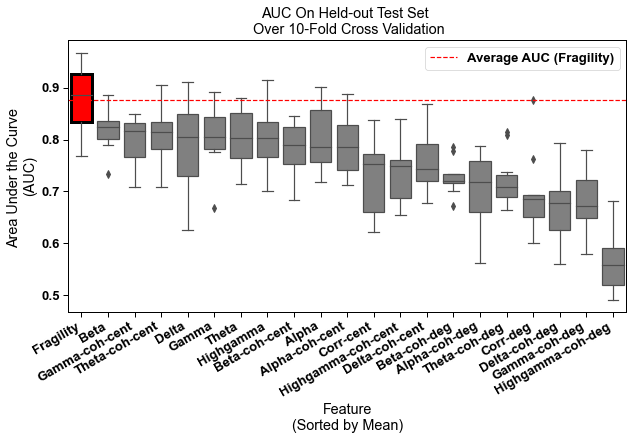

In [45]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Feature', y='AUC', order=order.index,
            data=feature_aucs_df, ax=ax,
           color='gray')
ax.axhline(feature_aucs_df[feature_aucs_df['Feature'] == 'Fragility']['AUC'].mean(),
          color='red', ls='--', label='Average AUC (Fragility)')
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   ha='right', rotation=30
                  )
ax.legend()
ax.set(title='AUC On Held-out Test Set \n Over 10-Fold Cross Validation',
      xlabel='Feature\n(Sorted by Mean)',
      ylabel='Area Under the Curve \n(AUC)')

# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f'delta_auc_plot_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')


## Compare the PR Across Feature Representations

In [49]:
feature_prs_df = pd.DataFrame.from_dict(feature_prs)
feature_prs_df['id_col'] = np.arange(10)

display(feature_prs_df.head())
feature_prs_df = pd.melt(feature_prs_df, id_vars='id_col',
                          var_name='feature', value_name='pr')
# display  
feature_prs_df.columns = [x.capitalize() if x in ['feature'] else x.upper() for x in feature_prs_df.columns]
feature_prs_df['Feature'] = feature_prs_df['Feature'].str.capitalize() 
display(feature_prs_df.head())

,fragility,beta,beta-coherence-centrality,alpha,theta-coherence-centrality,alpha-coherence-centrality,gamma,gamma-coherence-centrality,theta,delta,...,highgamma,correlation-degree,theta-coherence-degree,beta-coherence-degree,alpha-coherence-degree,highgamma-coherence-centrality,gamma-coherence-degree,delta-coherence-degree,highgamma-coherence-degree,id_col
0,0.881700,0.744085,0.786770,0.645399,0.745643,0.829614,0.786200,0.702064,0.709527,0.750803,...,0.784641,0.634391,0.571361,0.747668,0.748044,0.564413,0.613117,0.597503,0.438061,0
1,0.811345,0.799917,0.556219,0.820918,0.651236,0.596016,0.634245,0.577553,0.710997,0.762914,...,0.624270,0.603411,0.528985,0.468861,0.393556,0.607843,0.599147,0.453369,0.316716,1
2,0.926832,0.791390,0.652873,0.685981,0.650260,0.485659,0.761725,0.655964,0.592648,0.680459,...,0.665391,0.680691,0.482877,0.580109,0.454163,0.454897,0.474202,0.435401,0.282967,2
3,0.871919,0.829193,0.716134,0.756491,0.766109,0.763605,0.809842,0.756501,0.758633,0.642993,...,0.610416,0.639232,0.616634,0.711090,0.634498,0.685202,0.651732,0.506057,0.415766,3
4,0.952883,0.912915,0.556065,0.942254,0.537133,0.584119,0.837599,0.653731,0.911983,0.848509,...,0.771918,0.644851,0.379599,0.512387,0.559755,0.529328,0.479157,0.367219,0.338060,4


,ID_COL,Feature,PR
0,0,Fragility,0.881700
1,1,Fragility,0.811345
2,2,Fragility,0.926832
3,3,Fragility,0.871919
4,4,Fragility,0.952883


In [50]:
# map feature names to short-hand
feature_prs_df['Feature'] = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('Correlation', 'Corr') for x in feature_prs_df['Feature']]
display(feature_prs_df.head())

,ID_COL,Feature,PR
0,0,Fragility,0.881700
1,1,Fragility,0.811345
2,2,Fragility,0.926832
3,3,Fragility,0.871919
4,4,Fragility,0.952883


In [51]:
feature_prs_df = feature_prs_df.sort_values(by='PR', ascending=False)
order = feature_prs_df.groupby('Feature').median().sort_values(by='PR', ascending=False)
print(order.index)

Index(['Fragility', 'Beta', 'Alpha', 'Gamma', 'Theta', 'Alpha-coh-cent',
       'Gamma-coh-cent', 'Theta-coh-cent', 'Delta', 'Beta-coh-cent',
       'Corr-cent', 'Highgamma', 'Corr-deg', 'Alpha-coh-deg', 'Delta-coh-cent',
       'Beta-coh-deg', 'Gamma-coh-deg', 'Highgamma-coh-cent', 'Theta-coh-deg',
       'Delta-coh-deg', 'Highgamma-coh-deg'],
      dtype='object', name='Feature')


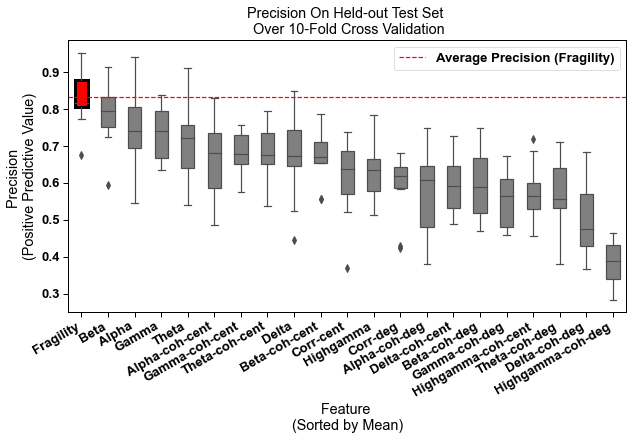

In [44]:
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titleweight'] = 'bold'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(x='Feature', y='PR', color='gray', order=order.index,
            data=feature_prs_df, ax=ax, width=0.5)
ax.axhline(feature_prs_df[feature_prs_df['Feature']=='Fragility']['PR'].mean(), 
           color='red', ls='--', label='Average Precision (Fragility)')
ax.legend()

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   ha='right', rotation=30
                  )
ax.set(title='Precision On Held-out Test Set \n Over 10-Fold Cross Validation',
      ylabel='Precision \n(Positive Predictive Value)',
      xlabel='Feature \n(Sorted by Mean)')
# Select which box you want to change    
mybox = ax.artists[0]

# Change the appearance of that box
mybox.set_facecolor('red')
mybox.set_edgecolor('black')
mybox.set_linewidth(3)

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
fname = f'delta_precision_plot_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')


## Compute Effect Size and P-Value For all Features

In addition to analyzing the AUC and Average-Precisions, we know that the stronger the classification, the more separated the predicted probability of success values should be when comparing success and failed outcomes. 

For each outcome group, we can quantify the distribution difference between the predicted probabilities of success with Cohen's D effect size measurement and a p-value stemmed from a hypothesis test.

Our null hypothesis is that the predicted probabilities of success come from the same distribution. A classifier that predicts randomly would of course fit under the null hypothesis. A classifier that can successfully use the feature representation of the iEEG data to predict outcome should be able to successfully separate the outcomes. In this scenario, we aren't so much interested in the p-value itself, as comparing the p-values across all features.

In [62]:
feature_df = pd.DataFrame(np.vstack([feature_pred_names, feature_pred_probs, feature_pred_subs]).T, columns=['name', 'proba', 'subject'])

outcomes = []
for subj in feature_df['subject']:
    # use excel file to set various data points
    pat_row = pat_df[pat_df['participant_id'] == 'sub-'+subj]
#     print(pat_row)
    outcomes.append(pat_row['outcome'].values[0])

feature_df['outcome'] = outcomes
feature_df['proba'] = pd.to_numeric(feature_df['proba'])

display(feature_df.head())

,name,proba,subject,outcome
0,fragility,0.180500,jh101,F
1,fragility,0.110000,jh103,F
2,fragility,0.386800,jh105,S
3,fragility,0.194000,la01,F
4,fragility,0.177333,la12,F


In [63]:
names = []
effs = []
effs_ublb = []
pvals_mw = []
pvals_lqrt = []
results_list = []

for name in feature_df['name'].unique():
    # create dabest and run effect size and pvalue computation
    feat_dabest = dabest.load(feature_df[feature_df['name'] == name], 
                              x='outcome', y='proba',
                             idx=('F', 'S'),
#                               ci=0.67
                             )
    
    results = feat_dabest.cohens_d.results
    
    effs.append(results['difference'].values[0])
    effs_ublb.append([results['bca_low'].values[0], results['bca_high'].values[0]])
    pvals_mw.append(results['pvalue_mann_whitney'].values[0])
    pvals_lqrt.append(feat_dabest.cohens_d.lqrt['pvalue_lqrt_unequal_var'].values[0])
    names.append(name)
    
    results_list.append(results)
    
    print(f'Computed {name}')
#     display(feat_dabest.cohens_d.results)
#     break

Computed fragility
Computed beta
Computed beta-coherence-centrality
Computed alpha
Computed theta-coherence-centrality
Computed alpha-coherence-centrality
Computed gamma
Computed gamma-coherence-centrality
Computed theta
Computed delta
Computed delta-coherence-centrality
Computed correlation-centrality
Computed highgamma
Computed correlation-degree
Computed theta-coherence-degree
Computed beta-coherence-degree
Computed alpha-coherence-degree
Computed highgamma-coherence-centrality
Computed gamma-coherence-degree
Computed delta-coherence-degree
Computed highgamma-coherence-degree


In [48]:
# map feature names to short-hand
names = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('correlation', 'corr').capitalize() for x in names]

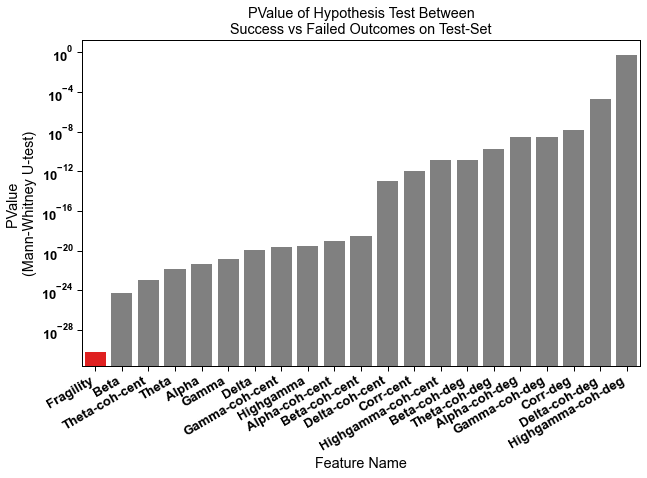

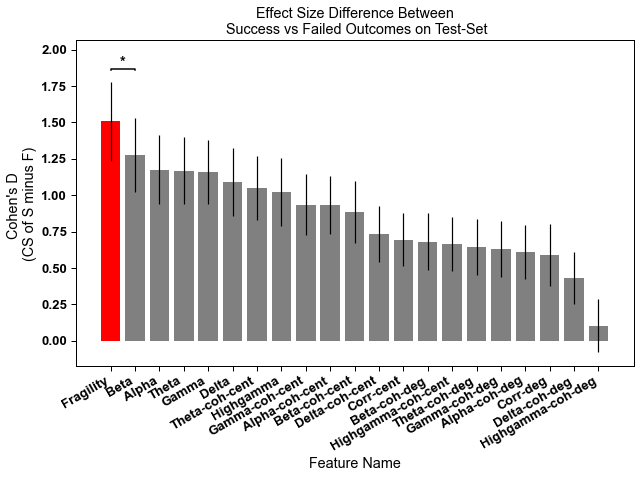

In [51]:
# create bar plot of the effect size and pvalue
ub = np.array(effs_ublb)[:, 0]
lb = np.array(effs_ublb)[:, 1]
outcome_df = pd.DataFrame((names, effs, ub, lb, pvals_mw, pvals_lqrt
                                    )).T
outcome_df.columns=['name', 'es', 'es_ub', 'es_lb', 'pval_mw', 'pval_lqrt']

yerr = np.vstack((outcome_df['es_lb'] - outcome_df['es'],
                  outcome_df['es_ub'] - outcome_df['es']))

figsize = (10, 6)

############################ create bar plot for pvalues ############################
colors = ['gray'] * len(order)
colors[0] = 'red'
fig, ax = plt.subplots(figsize=figsize)
order = outcome_df['pval_mw'].argsort()
sns.barplot(x='name', y='pval_mw', 
            palette=colors, order=outcome_df['name'][order],
            data=outcome_df, ax=ax)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set(title='PValue of Hypothesis Test Between\nSuccess vs Failed Outcomes on Test-Set',
      xlabel='Feature Name', ylabel='PValue \n(Mann-Whitney U-test)')

figpath = Path(figdir) / f'figure4-discriminationandprecision/'
figname = f'pvals_svsf_{clf_type}_quantilefeatures.pdf'
fig.savefig(figpath / figname, 
            bbox_inches='tight')


# get the hypothesis test for outcome 'es' for fragility vs beta
frag_results, beta_results = results_list[0], results_list[1]
scipy.stats.wilcoxon(frag_results.bootstraps.values[0], beta_results.bootstraps.values[0])

############################ create bar plot for es ############################
order = outcome_df['es'].argsort()[::-1]
colors = ['gray'] * len(order)
colors[0] = 'red'
fig, ax = plt.subplots(figsize=figsize)
ax.bar(x=np.arange(len(outcome_df['name'].unique())), tick_label=outcome_df['name'][order], 
       height=outcome_df['es'][order].tolist(), 
       yerr=yerr[1,order], color=colors)
ax.set(title="Effect Size Difference Between\n Success vs Failed Outcomes on Test-Set",
      xlabel='Feature Name', 
       ylabel="Cohen's D \n(CS of S minus F)")
# statistical annotation
x1, x2 = 0, 1 # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = outcome_df['es'].max() + 0.35, 0.01, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h/2.5, "*", ha='center', va='bottom', color=col)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1]+0.1])

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
figpath = Path(figdir) / f'figure4-discriminationandprecision/'
figname = f'es_svsf_{clf_type}_quantilefeatures.pdf'
fig.savefig(figpath / figname, 
            bbox_inches='tight')



# Analysis of the Prediction Probabilities Stratified By Clinical Variable (Clinical Complexity, Engel, ILAE)

The classification experiment is set up to optimize the split between successful and failed outcomes. This is reflected in the Engel class I, and ILAE class 1. Generally, ILAE class 2 is also considered a success, but not in our paper. Then our definition of clinical complexity (CC) measures the different coarse epilepsy etiologies, which do not directly measure surgical outcome. However, based on observational studies, we do know that each of these clinical complexities correlate with a decreasing rate of surgical success.

Here we show that neural fragility does capture this trend when used as a feature representation for predicting surgical outcome. This is important to see because we can postulate that this occurs because fragility is capturing portions of the true SOZ, which if not fully resected, results in some improvement possibly with Engel class II, or III (where there is some level of improvement), but not fully seizure free.

,CS,CC,ILAE,ENGEL,cv_index
0,0.122,4,6,4,0.0
1,0.168,4,6,4,0.0
2,0.258,4,6,4,0.0
3,0.174,4,6,4,0.0
4,0.192,3,6,4,0.0
...,...,...,...,...,...
1698,0.820,2,2,1,9.0
1699,0.840,2,2,1,9.0
1700,0.462,1,1,1,9.0
1701,0.566,1,1,1,9.0


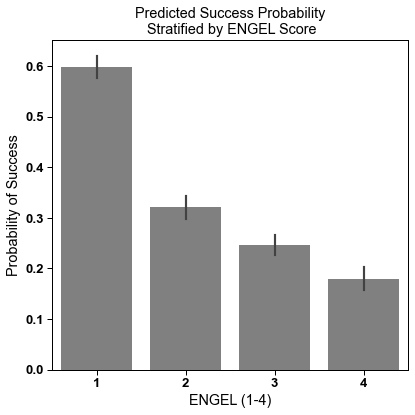

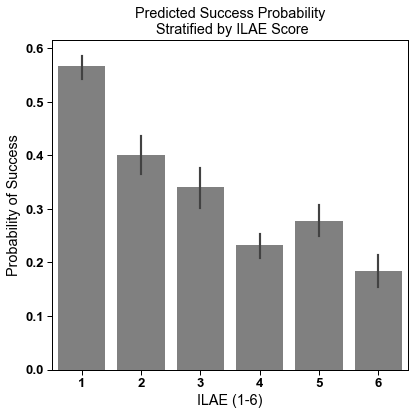

In [80]:
colors = ['blue', 'orange', 'green', 'magenta']

feature_aucs = dict()

# for idx, (feature_name, nested_scores) in enumerate(nested_scores_feature.items()):
for idx in range(1):
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[feature_name]
    color = colors[idx]

    predict_probas = nested_scores['validate_ypred_prob']
    ytrues = nested_scores['validate_ytrue']
    subjects = nested_scores['validate_subjects']
    
    y_probs = []
    cc_scores = []
    ilae_scores = []
    engel_scores = [] #collections.defaultdict(list)
    cv_indices = []
    
    for jdx in range(len(ytrues)):
        for kdx, (y_proba, y, subject) in enumerate(zip(predict_probas[jdx], 
                                                        ytrues[jdx], 
                                                        subjects[jdx])):
            # use excel file to set various data points
            pat_row = pat_df[pat_df['participant_id'] == ('sub-' + subject)]
            cc = pat_row['clinical_complexity'].values[0]
            ilae = pat_row['ilae_score'].values[0]
            engel = pat_row['engel_score'].values[0]

            y_probs.append(y_proba)
            cc_scores.append(cc)
            ilae_scores.append(ilae)
            engel_scores.append(engel)
            cv_indices.append(jdx)

    cc_df = pd.DataFrame(np.vstack((y_probs, cc_scores, ilae_scores, engel_scores, cv_indices)).T, 
                         columns=('CS', 'CC', 'ILAE', 'ENGEL', 'cv_index'))
#     cc_df = pd.to_numeric(cc_df)
    cc_df = cc_df.apply(pd.to_numeric)
    cc_df[['CC', 'ILAE', 'ENGEL']] = cc_df[['CC', 'ILAE', 'ENGEL']].astype(int)
    display(cc_df)
    
    covname = 'ENGEL'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["figure.titleweight"] = "bold"
    sns.set_context('paper', font_scale=1.5)
#     plt.rc("figure.title", labelweight="bold")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
    sns.barplot(x=covname, y='CS', data=cc_df, ax=ax, color='gray')
    ax.set(
        ylabel='Probability of Success',
        xlabel=f'{covname.upper()} (1-4)',
        title=f'Predicted Success Probability\n Stratified by {covname.upper()} Score'
    )
    fig.tight_layout()
    figpath = figdir / 'cc_stratified'
    figpath = Path(figdir) / f'figure5-clinical_covariates/'

    figpath.mkdir(exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}_{covname}_stratified_barplot.pdf')
    
    covname = 'ILAE'
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["figure.titleweight"] = "bold"
    sns.set_context('paper', font_scale=1.5)
#     plt.rc("figure.title", labelweight="bold")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharey=True)
    sns.barplot(x=covname, y='CS', data=cc_df, ax=ax, color='gray')
    ax.set(
        ylabel='Probability of Success',
        xlabel=f'{covname.upper()} (1-6)',
        title=f'Predicted Success Probability\n Stratified by {covname.upper()} Score'
    )
    fig.tight_layout()
    figpath = figdir / 'cc_stratified'
    figpath = Path(figdir) / f'figure5-clinical_covariates/'

    figpath.mkdir(exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}_{covname}_stratified_barplot.pdf')
    break

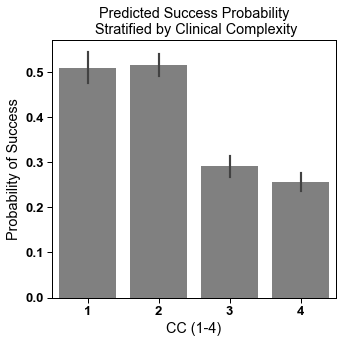

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
sns.barplot(x='CC', y='CS', data=cc_df, ax=ax, color='gray')
ax.set(
    ylabel='Probability of Success',
    xlabel='CC (1-4)',
    title='Predicted Success Probability\n Stratified by Clinical Complexity'
)

fig.tight_layout()
figpath = figdir / 'cc_stratified'
# figpath = Path(f'/Users/adam2392/Dropbox/Apps/Overleaf/Models of Intracranial EEG Networks For Epileptogenic Zone Localization/figures/figure5-clinical_covariates/')
# figpath.mkdir(exist_ok=True)
# fig.savefig(figpath / f'{feature_name}_cc_stratified_barplot.pdf')

In [83]:
display(cc_df.head())

cc_df['ENGEL'] = cc_df['ENGEL'].astype(str)
cc_df['CC'] = cc_df['CC'].astype(str)

,CS,CC,ILAE,ENGEL,cv_index
0,0.122,4,6,4,0.0
1,0.168,4,6,4,0.0
2,0.258,4,6,4,0.0
3,0.174,4,6,4,0.0
4,0.192,3,6,4,0.0


In [84]:
cc_dabest = dabest.load(cc_df, 
                        x='CC', y='CS', 
#                         idx=(
#                             ['2', '3'],
#                              ['2', '4'],
#                              ['3', '4'],
#                             ),
                        idx=['1','2','3','4'],
#                         idx=sorted(cc_df['ENGEL'].unique()), 
                        ci=95)
                                
cc_dabest.cohens_d

DABEST v0.3.0
             
Good evening!
The current time is Tue Nov 17 22:05:39 2020.

The unpaired Cohen's d between 1 and 2 is 0.02 [95%CI -0.119, 0.157].
The p-value of the two-sided permutation t-test is 0.76. 

The unpaired Cohen's d between 1 and 3 is -0.779 [95%CI -0.941, -0.615].
The p-value of the two-sided permutation t-test is 0.0. 

The unpaired Cohen's d between 1 and 4 is -0.962 [95%CI -1.14, -0.806].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.cohens_d.statistical_tests`

In [85]:
display(cc_dabest.cohens_d.lqrt)

,control,test,control_N,test_N,pvalue_lqrt_equal_var,statistic_lqrt_equal_var,pvalue_lqrt_unequal_var,statistic_lqrt_unequal_var
0,1,2,338,552,0.76,0.080562,0.76,0.079265
1,1,3,338,415,0.00,105.812784,0.00,108.588820
2,1,4,338,398,0.00,152.560256,0.00,173.012046


In [86]:
display(cc_dabest.cohens_d.results)

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,...,resamples,random_seed,pvalue_permutation,permutation_count,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,1,2,338,552,Cohen's d,False,0.019977,95,-0.118537,0.157459,...,5000,12345,0.7604,5000,7.759220e-01,-0.284751,7.724613e-01,-0.289245,7.998859e-01,92344.0
1,1,3,338,415,Cohen's d,False,-0.779020,95,-0.940557,-0.615102,...,5000,12345,0.0000,5000,3.823306e-23,10.325826,1.082581e-24,10.632460,2.807801e-19,96783.0
2,1,4,338,398,Cohen's d,False,-0.962217,95,-1.137867,-0.805669,...,5000,12345,0.0000,5000,7.271382e-32,12.542048,5.796395e-35,13.008709,7.387830e-26,97485.5


# Interpretability

In [90]:
pat_df = read_participants_tsv(bids_root)
print(study_path)

data/derivatives


In [96]:
interp_fpaths = [f for f in (study_path / 'interpretability').glob('*') if f.suffix == '.json']

names = []
scores = []
results = []

avg_scores = dict()
print(len(interp_fpaths))

for fpath in interp_fpaths:
    feature_name = fpath.name.split('_')[-1].split('.')[0]
    with open(fpath, 'r') as fin:
        interp_scores = json.load(fin)
        
    soz_list = interp_scores['spatial_soz']
    sozc_list = interp_scores['spatial_sozc']
    subject_groups = interp_scores['subjects']

    ratios = []
    outcomes = []
    for soz, sozc, subject in zip(soz_list, sozc_list, subject_groups):
        # use excel file to set various data points
        pat_row = pat_df[pat_df['participant_id'] == 'sub-'+subject]
        cc = pat_row['clinical_complexity'].values[0]
        outcome = pat_row['outcome'].values[0]

        ratios.append(np.nanmean(soz) / (np.nanmean(sozc) + np.nanmean(soz)))
        outcomes.append(outcome)

    df = pd.DataFrame(np.vstack((ratios, outcomes)).T, 
#                       columns=('soz', 'sozc')
                        columns=['score', 'outcome']
                     )
#     df = pd.melt(df, var_name='outcome', value_name='score')
    df[df['score'] == 'nan'] = 0
    df['score'] = pd.to_numeric(df['score'])

    print(feature_name)
    soz_dabest = dabest.load(df, x='outcome', y='score', 
#                         idx=(
#                             ['2', '3'],
#                              ['2', '4'],
#                              ['3', '4'],
#                             ),
                        idx=['S','F'],
#                         idx=sorted(cc_df['ENGEL'].unique()), 
                        ci=95)
    es = soz_dabest.cohens_d.results['difference'].values
    results.append(soz_dabest.cohens_d.results)
    names.append(feature_name)

21
highgamma
beta
beta-coherence-centrality
fragility
correlation-centrality
alpha-coherence-degree
gamma
highgamma-coherence-degree
beta-coherence-degree
theta-coherence-degree
correlation-degree
gamma-coherence-centrality
delta-coherence-degree
alpha
theta
delta-coherence-centrality
delta
theta-coherence-centrality
gamma-coherence-degree
alpha-coherence-centrality
highgamma-coherence-centrality


In [93]:
pvals = {}
for name, result in zip(names, results):
    pval = result['pvalue_mann_whitney'].values[0]
    pvals[name] = pval
    
pprint(pvals)

{'alpha': 3.001297431947798e-13,
 'alpha-coherence-centrality': 4.218504460343371e-05,
 'alpha-coherence-degree': 0.029352561868318344,
 'beta': 2.1962554494806117e-17,
 'beta-coherence-centrality': 0.001793994581312549,
 'beta-coherence-degree': 0.03720366117511123,
 'correlation-centrality': 0.0009633420312115968,
 'correlation-degree': 0.000156847329291443,
 'delta': 7.546486579474267e-09,
 'delta-coherence-centrality': 3.057745806714893e-05,
 'delta-coherence-degree': 0.912280679210279,
 'fragility': 4.972942391821433e-18,
 'gamma': 4.596619938378418e-07,
 'gamma-coherence-centrality': 4.578222663340791e-08,
 'gamma-coherence-degree': 0.7170102547931989,
 'highgamma': 0.00011167516460455964,
 'highgamma-coherence-centrality': 0.0020429389281530546,
 'highgamma-coherence-degree': 0.03834114733688794,
 'theta': 9.56012112449053e-14,
 'theta-coherence-centrality': 1.1042327541071513e-08,
 'theta-coherence-degree': 0.8097921490967228}


In [94]:
# map feature names to short-hand
names = [x.replace('coherence', 'coh').
                          replace('degree', 'deg').
                          replace('centrality', 'cent').
                          replace('correlation', 'corr').capitalize() for x in names]


[Text(0.5, 1.0, 'Interpretability Ratios of Features \nStratified By Surgical Outcomes'),
 Text(0, 0.5, "Absolute Effect Size \n(Cohen's D)"),
 Text(0.5, 0, 'Feature \n (Ordered by Mean)')]

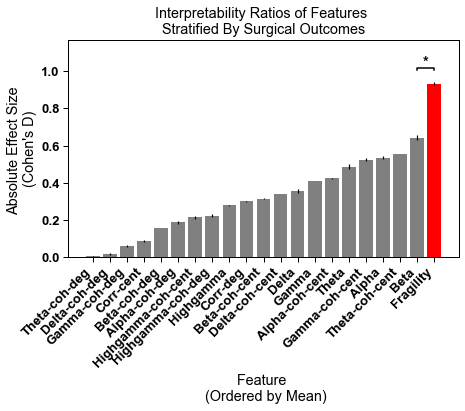

In [95]:
feat_es = []
y_errs = []
for name, result in zip(names, results):
    es, lb, ub = result['difference'].values[0], result['bca_low'].values[0], result['bca_high'].values[0]
    feat_es.append(np.abs(es))
    y_errs.append(np.abs((ub+lb))/2 - np.abs(es))
    
idx_order = np.argsort(feat_es)
    
colors = ['gray'] * len(idx_order)
colors[-1] = 'red'

sns.set_context('paper', font_scale=1.5)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x=np.arange(len(names)), color=colors,
       height=np.array(feat_es)[idx_order], 
       yerr=np.array(y_errs)[idx_order], 
       tick_label=np.array(names)[idx_order])
xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, 
                   rotation = 45, ha="right")
# statistical annotation
x1, x2 = 19, 20  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = np.max(feat_es) + 0.075, 0.01, 'k'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h/2.5, "*", ha='center', va='bottom', color=col)
ylim = ax.get_ylim()
ax.set_ylim([ylim[0], ylim[1]+0.1])

ax.set(
    title=f'Interpretability Ratios of Features \nStratified By Surgical Outcomes',
      ylabel="Absolute Effect Size \n(Cohen's D)",
      xlabel='Feature \n (Ordered by Mean)'
)
# fig.savefig(figdir / 'figure6-interpretability/quantile_ratios_samehyperparameters.pdf', 
#             bbox_inches='tight')

# Calibration Curve

Next we can compute a calibration curve for the CV experiment. A calibration curve shows the predicted probabilities of success against the true proportion of success outcomes taken over subsets of the data. A perfectly calibrated curve is simply the `y=x` curve, which implies that your classifier predicted probability value is perfectly reflective of the chances of this patient being a success. 

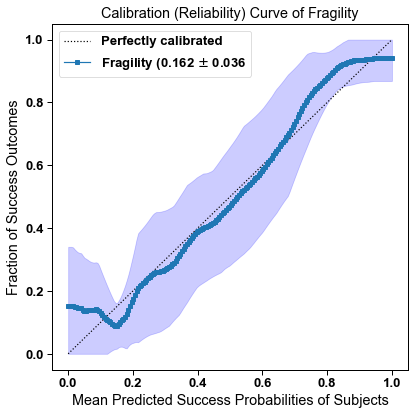

done


In [35]:
#
plt.rcParams['font.weight'] = 'bold'
sns.set_context("paper", font_scale=1.5)
# plt.figure(figsize=(6,6))

# ax1 = plt.subplot2grid((2, 1), (0, 0), rowspan=1)
fig, ax1 = plt.subplots(figsize=(6,6))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

colors = ['blue', 'orange', 'green', 'magenta']
for idx in range(1):
    name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[name]

    y_predict_prob = nested_scores['validate_ypred_prob']
    y_trues = nested_scores['validate_ytrue']


    frac_pred_vals = []
    mean_pred_values = np.linspace(0, 1.0, 200)
    brier_scores = []
    for i, (y, prob_pos) in enumerate(zip(y_trues, y_predict_prob)):
        prob_pos = np.array(prob_pos)#[:, 1]
        # compute calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y, prob_pos, n_bins=10, strategy="quantile"
        )

        clf_score = np.round(
            brier_score_loss(y, prob_pos, pos_label=np.array(y).max()), 3
        )

        # create a linear interpolation of the calibration
        interp_frac_positives = np.interp(
            mean_pred_values, mean_predicted_value, fraction_of_positives
        )
#         interp_frac_positives[0] = 0.0

        # store curves + scores
        brier_scores.append(clf_score)
        frac_pred_vals.append(interp_frac_positives)

    mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
    ax1.plot(
        mean_pred_values,
        mean_frac_pred_values,
        "s-",
        label=rf"{name.capitalize()} ({np.round(np.mean(brier_scores),3)} $\pm$ {np.round(np.std(brier_scores), 3)}",
    )

    # get upper and lower bound for tpr
    std_fpv = np.std(frac_pred_vals, axis=0)
    tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
    tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
    ax1.fill_between(
        mean_pred_values,
        tprs_lower,
        tprs_upper,
        color=color,
        alpha=0.2,
        # label=r"$\pm$ 1 std. dev.",
    )

# ax1.plot()
ax1.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel='Mean Predicted Success Probabilities of Subjects'
)

ax1.legend(
#     loc=(1.04, 0)
          )
ax1.set_title("Calibration (Reliability) Curve of Fragility")

plt.tight_layout()
figpath = Path(figdir) / f'discrimination_and_calibration/'
fname = f'calibration_curve_{clf_type}_quantilefeatures.pdf'
# fig.savefig(figpath / fname, bbox_inches='tight')
plt.show()
print('done')

# Feature Permutations for Importances over the Spatiotemporal Heatmap

We can run permutations on the input data matrix for the classifier, and measure corresponding effects on the statistic of interest, AUC. In this way, we can parse out which quantiles of the neural fragility SOZ, and $SOZ^C$ are important and at what times to predict surgical outcome.

For more information on permutation feature importances computation, see: https://scikit-learn.org/stable/modules/permutation_importance.html

In [64]:
# number of quantiles used (10 per SOZ and SOZ^C)
IMAGE_HEIGHT = 20

(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)
(2100,)


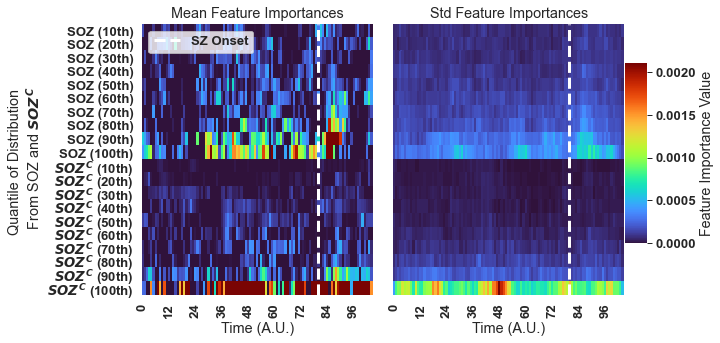

In [37]:
colors = ['blue', 'orange', 'green', 'magenta']

# loop over top 4
for idx in range(4):
    feature_name = np.asarray(auc_feat_names)[auc_sorted_inds][idx]
    color = colors[idx]
    
    nested_scores = nested_scores_feature[feature_name]
    color = colors[idx]

    imp_vals = []
    imp_std = []
    for cv_index in range(len(nested_scores['validate_imp_mean'])):
        _imp_vals = np.array(nested_scores['validate_imp_mean'][cv_index])
        _imp_std = np.array(nested_scores['validate_imp_std'][cv_index])

        print(_imp_vals.shape)
        best_window = nested_scores['hyperparameters'][cv_index][0]
        onsetwin = np.abs(best_window[0])

        X_shape = (IMAGE_HEIGHT, np.abs(best_window).sum())
        
        imp_vals.append(_imp_vals)
        imp_std.append(_imp_std)
        
    # average over the cross-validation folds
    imp_vals = np.mean(imp_vals, axis=0)
    imp_std = np.mean(imp_std, axis=0)
        
    # do a heatmap
    sns.set_context("paper", font_scale=1.5)
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), 
#                             sharey=True 
                           )
    cbar_ax = fig.add_axes([.88, .3, .03, .5])
    ax = axs[0]
    vmax=np.quantile(np.vstack((imp_vals.flatten(), imp_std.flatten())), 0.95)
    # vmax = np.quantile(imp_vals.flatten(), 0.95),
#     yticklabels = [
#         rf'$\mu$(SOZ)', r'$\sigma$(SOZ)', 
#                                   r'$\mu$($SOZ^C$)', r'$\sigma$($SOZ^C$)'
#     ]
    yticklabels = [f'SOZ ({idx*10}th)' for idx in range(1, 11)] + [f'$SOZ^C$ ({idx*10}th)' for idx in range(1, 11)] 
    
    ax = sns.heatmap(imp_vals.reshape(X_shape), vmax=vmax, vmin=0,
    #                  norm=LogNorm(imp_vals.min(),imp_vals.max()), 
                     yticklabels=yticklabels,
                     cmap='turbo', 
                     ax=ax,
                    cbar_ax=None, cbar=False,
                    )
    ax.set(title=f'Mean Feature Importances',# for {feature_name.capitalize()}",
           ylabel='Quantile of Distribution \n From SOZ and $SOZ^C$', 
           xlabel='Time (A.U.)')
    ax.axvline(onsetwin, lw=3, ls='--', color='white', label='SZ Onset')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2])
#     ax.set_xticklabels(ax.get_xticklabels()[::2], 
#                        rotation=45
#                       )
    # for label in ax.xaxis.get_ticklabels()[::2]:
    #     label.set_visible(False)
    ax.legend()

    ax = axs[1]
    # vmax=np.quantile(imp_std.flatten(), 0.95),
    ax = sns.heatmap(imp_std.reshape(X_shape),  
    #                  vmax=vmax, vmin=0,
    #                  norm=LogNorm(imp_std.min(),imp_std.max()),  
    #                  yticklabels=[rf'$\mu$(SOZ)', r'$\sigma$(SOZ)', 
    #                               r'$\mu$($SOZ^C$)', r'$\sigma$($SOZ^C$)'],
                     cmap='turbo', ax=ax,
                     cbar=True, 
                     cbar_kws={'label': 'Feature Importance Value'},
                     cbar_ax=cbar_ax)
    ax.set(title="Std Feature Importances",
    #        ylabel='Feature(s) \nFrom SOZ and nSOZ', 
           yticks=[],
           xlabel='Time (A.U.)')
    
    ax.axvline(onsetwin, lw=3, ls='--', color='white', label='SZ Onset')
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2])
#     cbar_ax.set_title('Feature Importance Value')
#     cbar = fig.colorbar(, ax=axs.ravel().tolist(), shrink=0.95)
#     cbar.set_title('Feature Importance Value')
#     cbar.set_ticks(np.arange(0, 1.1, 0.5))
#     cbar.set_ticklabels(['low', 'medium', 'high'])

#     ax.set_xticklabels(ax.get_xticklabels()[::2], 
#                        rotation=45
#                       )
    # axs[1].set_yticks([])
    # for label in ax.xaxis.get_ticklabels()[::2]:
    #     label.set_visible(False)
#     ax.legend()
    fig.tight_layout(rect=[0, 0, .9, 1])
#     fig.tight_layout()
    figpath = figdir / 'feature_importances'
    figpath.mkdir(parents=True, exist_ok=True)
#     fig.savefig(figpath / f'{feature_name}-feature_importances-fixedwindow-20quantilefeatures-window-80to25.pdf', 
#                 bbox_inches='tight')
    break
